#### Imports

In [1]:
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt

import nltk
import re
from string import punctuation

# download necessary corpus and models from nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

from urllib.parse import urlparse
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from transformers import pipeline

C:\Users\sawye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sawye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sawye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\sawye\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sawye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading pack

#### Load multiple datasets

##### Originally I had a seperate testing dataset, but it differed too much from the main dataset, so I will combine all of them and simply shuffle them and use train-test-split

##### I want to use multiple different datasets to train them to be flexibile and not to overfit

In [2]:
# Get the dataset
path1 = kagglehub.dataset_download("shalmamuji/spam-email-classification", "email_classification_dataset.csv")
path2 = kagglehub.dataset_download("abdallahwagih/spam-emails", "spam.csv")

df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)

#### EDA

In [3]:
df1.head(5)

,id,email,label
0,2685,From: support@legitcompany.com\nSubject: Regar...,ham
1,5857,From: noreply@softwareupdates.com\nSubject: We...,ham
2,2399,From: noreply@softwareupdates.com\nSubject: Im...,ham
3,3244,From: info@customerservice.co\nSubject: Team S...,ham
4,2844,From: info@customerservice.co\nSubject: Team S...,ham


In [4]:
df2.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  int64 
 1   email   10000 non-null  object
 2   label   10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


##### There are no null values

In [7]:
#### Remove the id column
df1 = df1.drop(columns=['id'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   10000 non-null  object
 1   label   10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


##### Rename the columns of the datasets all to the same names and order the columns the same way (make them homogenous)

In [8]:
df1 = df1.rename(columns={'email': 'Message', 'label': 'Category'})

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   10000 non-null  object
 1   Category  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [10]:
# swapping columns of training dataset 1
cols = list(df2.columns)

idx1, idx2 = cols.index('Category'), cols.index('Message')
cols[idx1], cols[idx2] = cols[idx2], cols[idx1]

df2 = df2[cols]

df2.head(1)

,Message,Category
0,"Go until jurong point, crazy.. Available only ...",ham


##### Order the data into email Subject, Sender, and Body since some of the datasets include Subject and From. For the ones that don't have it just create columns filled with "Subject not given" and "Sender not given"

In [11]:
df1.values

array([['From: support@legitcompany.com\nSubject: Regarding Your Recent Inquiry\n\nThank you for reaching out regarding [your inquiry]. We have reviewed your request and will get back to you within 24 hours with a detailed response. Sincerely, Customer Service Team',
        'ham'],
       ['From: noreply@softwareupdates.com\nSubject: Weekly Newsletter - Latest Updates\n\nPlease find attached your invoice for the services rendered in June. The total amount due is $X.XX. Payment is due by [Date]. If you have any questions, please reply to this email. Thank you, Accounts Department',
        'ham'],
       ['From: noreply@softwareupdates.com\nSubject: Important: Software Update Notification\n\nThank you for your order #6789. Your items will be shipped within 2 business days. You can track your order here: [link to legitimate tracking page]. Best regards, Legit Company Support',
        'ham'],
       ...,
       ["From: team@projectmanagement.com\nSubject: Feedback Request: Your Recent P

In [12]:
df1['Sender'] = ''
df1['Subject'] = ''
df1['Body'] = ''

index = 0
for text in df1['Message']:
    # Extract Sender
    from_match = re.search(r'From:\s*(.+)', text, re.IGNORECASE)
    sender = from_match.group(1) if from_match else None

    # Extract Subject
    subj_match = re.search(r'\nSubject:\s*(.+)', text, re.IGNORECASE)
    subject = subj_match.group(1) if subj_match else None

    # Extract Body (everything after the first blank line \n\n)
    body = text.split('\n\n', 1)[1] if '\n\n' in text else text

    df1.at[index, 'Sender'] = sender
    df1.at[index, 'Subject'] = subject
    df1.at[index, 'Body'] = body 

    index += 1

In [13]:
df1.head(5)

,Message,Category,Sender,Subject,Body
0,From: support@legitcompany.com\nSubject: Regar...,ham,support@legitcompany.com,Regarding Your Recent Inquiry,Thank you for reaching out regarding [your inq...
1,From: noreply@softwareupdates.com\nSubject: We...,ham,noreply@softwareupdates.com,Weekly Newsletter - Latest Updates,Please find attached your invoice for the serv...
2,From: noreply@softwareupdates.com\nSubject: Im...,ham,noreply@softwareupdates.com,Important: Software Update Notification,Thank you for your order #6789. Your items wil...
3,From: info@customerservice.co\nSubject: Team S...,ham,info@customerservice.co,Team Stand-up at 10 AM,Please find attached your invoice for the serv...
4,From: info@customerservice.co\nSubject: Team S...,ham,info@customerservice.co,Team Stand-up at 10 AM,Here's your weekly dose of news and updates fr...


In [14]:
df2['Sender'] = 'Sender not given'
df2['Subject'] = 'Subject not given'
df2['Body'] = ''

index = 0
for text in df2['Message']:
    # Extract Sender
    from_match = re.search(r'From:\s*(.+)', text, re.IGNORECASE)
    sender = from_match.group(1) if from_match else None

    # Extract Subject
    subj_match = re.search(r'\nSubject:\s*(.+)', text, re.IGNORECASE)
    subject = subj_match.group(1) if subj_match else None

    # Extract Body (everything after the first blank line \n\n)
    body = text.split('\n\n', 1)[1] if '\n\n' in text else text

    if sender is not None:
        df2.at[index, 'Sender'] = sender
    
    if subject is not None:
        df2.at[index, 'Subject'] = subject
        
    df2.at[index, 'Body'] = body 

    index += 1

In [15]:
df2.head(5)

,Message,Category,Sender,Subject,Body
0,"Go until jurong point, crazy.. Available only ...",ham,Sender not given,Subject not given,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...,ham,Sender not given,Subject not given,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,Sender not given,Subject not given,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...,ham,Sender not given,Subject not given,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro...",ham,Sender not given,Subject not given,"Nah I don't think he goes to usf, he lives aro..."


#### Combine training data

In [16]:
column_names = ['Message', 'Category', 'Sender', 'Subject', 'Body']
df = pd.DataFrame(np.vstack([df1, df2]), columns=column_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15572 entries, 0 to 15571
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   15572 non-null  object
 1   Category  15572 non-null  object
 2   Sender    15572 non-null  object
 3   Subject   15572 non-null  object
 4   Body      15572 non-null  object
dtypes: object(5)
memory usage: 608.4+ KB


In [17]:
# put the Category column to the very end
column_to_move = 'Category'

cols = [col for col in df.columns if col != 'Category']
cols.append(column_to_move)

df = df[cols]

In [18]:
df.head(5)

,Message,Sender,Subject,Body,Category
0,From: support@legitcompany.com\nSubject: Regar...,support@legitcompany.com,Regarding Your Recent Inquiry,Thank you for reaching out regarding [your inq...,ham
1,From: noreply@softwareupdates.com\nSubject: We...,noreply@softwareupdates.com,Weekly Newsletter - Latest Updates,Please find attached your invoice for the serv...,ham
2,From: noreply@softwareupdates.com\nSubject: Im...,noreply@softwareupdates.com,Important: Software Update Notification,Thank you for your order #6789. Your items wil...,ham
3,From: info@customerservice.co\nSubject: Team S...,info@customerservice.co,Team Stand-up at 10 AM,Please find attached your invoice for the serv...,ham
4,From: info@customerservice.co\nSubject: Team S...,info@customerservice.co,Team Stand-up at 10 AM,Here's your weekly dose of news and updates fr...,ham


#### Encode Categorical data

In [19]:
 # binary encode  Category
mapping = {'ham': 0, 'spam': 1}

df['Category'] = df['Category'].map(mapping)

In [20]:
df.head(10)

,Message,Sender,Subject,Body,Category
0,From: support@legitcompany.com\nSubject: Regar...,support@legitcompany.com,Regarding Your Recent Inquiry,Thank you for reaching out regarding [your inq...,0
1,From: noreply@softwareupdates.com\nSubject: We...,noreply@softwareupdates.com,Weekly Newsletter - Latest Updates,Please find attached your invoice for the serv...,0
2,From: noreply@softwareupdates.com\nSubject: Im...,noreply@softwareupdates.com,Important: Software Update Notification,Thank you for your order #6789. Your items wil...,0
3,From: info@customerservice.co\nSubject: Team S...,info@customerservice.co,Team Stand-up at 10 AM,Please find attached your invoice for the serv...,0
4,From: info@customerservice.co\nSubject: Team S...,info@customerservice.co,Team Stand-up at 10 AM,Here's your weekly dose of news and updates fr...,0
5,From: survey@retailfeedback.com\nSubject: Invo...,survey@retailfeedback.com,Invoice for Services Rendered,"Hey [Friend's Name], it's been a while! How ha...",0
6,From: info@customerservice.co\nSubject: Invoic...,info@customerservice.co,Invoice for Services Rendered,"Hi team, just a reminder about our Project Alp...",0
7,From: noreply@softwareupdates.com\nSubject: Fe...,noreply@softwareupdates.com,Feedback Request: Your Recent Purchase,"Hi everyone, I've uploaded the photos from our...",0
8,From: survey@retailfeedback.com\nSubject: Your...,survey@retailfeedback.com,Your Order #6789 Confirmed,This is an automated notification regarding an...,0
9,From: family@homemail.net\nSubject: Important:...,family@homemail.net,Important: Software Update Notification,Thank you for your order #6789. Your items wil...,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15572 entries, 0 to 15571
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   15572 non-null  object
 1   Sender    15572 non-null  object
 2   Subject   15572 non-null  object
 3   Body      15572 non-null  object
 4   Category  15572 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 608.4+ KB


#### Explore the Text

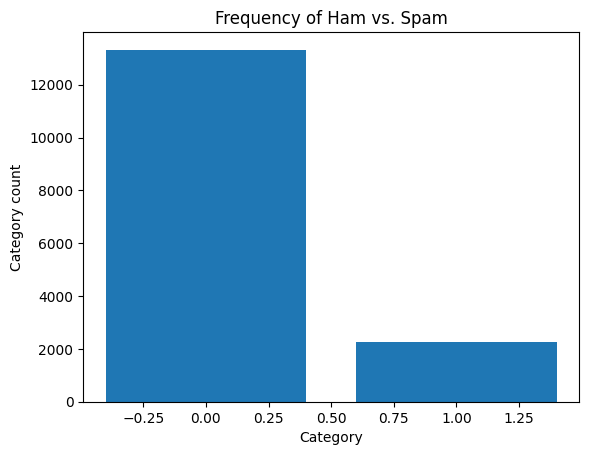

In [22]:
# see the ratio of ham and spam
plt.bar(df['Category'].value_counts().index, df['Category'].value_counts().values)
plt.title('Frequency of Ham vs. Spam')
plt.xlabel('Category')
plt.ylabel('Category count')
plt.show()

In [23]:
def sentence_metrics(sentence_array):
    total_sentences = 0
    total_messages = len(sentence_array)

    for text in sentence_array:
        sentence_in_text = nltk.sent_tokenize(text)
        total_sentences += len(sentence_in_text)
    
    avg_sentence_per_message = total_sentences / total_messages

    return total_sentences, avg_sentence_per_message

In [24]:
# view the total sentences and avg sentences per email of the datasets
total_sent, avg_sent_per_email = sentence_metrics(df['Body'])

print("Sentences in training dataset: ", total_sent)
print("Average sentences per email in training dataset: ", avg_sent_per_email)

Sentences in training dataset:  49625
Average sentences per email in training dataset:  3.186809658361161


In [25]:
def word_email_metrics(sentence_array, total_sentences):
    total_words = 0
    total_sentences = total_sentences

    for text in sentence_array:
        words_in_text = nltk.word_tokenize(text)

        total_words += len(words_in_text)

    avg_words_per_sentence = total_words / total_sentences
    return total_words, avg_words_per_sentence 

In [26]:
# view the total words and avg words per email of the datasets
total_words, avg_words_per_sent = word_email_metrics(df['Body'], total_sent)

print("Words in training dataset: ", total_words)
print("Average words per sentence in training dataset: ", avg_words_per_sent)

Words in training dataset:  476607
Average words per sentence in training dataset:  9.604171284634761


In [27]:
df['Message'].values

array(['From: support@legitcompany.com\nSubject: Regarding Your Recent Inquiry\n\nThank you for reaching out regarding [your inquiry]. We have reviewed your request and will get back to you within 24 hours with a detailed response. Sincerely, Customer Service Team',
       'From: noreply@softwareupdates.com\nSubject: Weekly Newsletter - Latest Updates\n\nPlease find attached your invoice for the services rendered in June. The total amount due is $X.XX. Payment is due by [Date]. If you have any questions, please reply to this email. Thank you, Accounts Department',
       'From: noreply@softwareupdates.com\nSubject: Important: Software Update Notification\n\nThank you for your order #6789. Your items will be shipped within 2 business days. You can track your order here: [link to legitimate tracking page]. Best regards, Legit Company Support',
       ..., 'Pity, * was in mood for that. So...any other suggestions?',
       "The guy did some bitching but I acted like i'd be interested in b

##### Must later parse for From: and Subject:, and exclude \n, etc.

##### Word frequency distribution

In [28]:
# tokenize
email_tokens = []

for email in df['Body']:
    tokens = nltk.word_tokenize(email)

    email_tokens.append(tokens)

In [29]:
email_tokens

[['Thank',
  'you',
  'for',
  'reaching',
  'out',
  'regarding',
  '[',
  'your',
  'inquiry',
  ']',
  '.',
  'We',
  'have',
  'reviewed',
  'your',
  'request',
  'and',
  'will',
  'get',
  'back',
  'to',
  'you',
  'within',
  '24',
  'hours',
  'with',
  'a',
  'detailed',
  'response',
  '.',
  'Sincerely',
  ',',
  'Customer',
  'Service',
  'Team'],
 ['Please',
  'find',
  'attached',
  'your',
  'invoice',
  'for',
  'the',
  'services',
  'rendered',
  'in',
  'June',
  '.',
  'The',
  'total',
  'amount',
  'due',
  'is',
  '$',
  'X.XX',
  '.',
  'Payment',
  'is',
  'due',
  'by',
  '[',
  'Date',
  ']',
  '.',
  'If',
  'you',
  'have',
  'any',
  'questions',
  ',',
  'please',
  'reply',
  'to',
  'this',
  'email',
  '.',
  'Thank',
  'you',
  ',',
  'Accounts',
  'Department'],
 ['Thank',
  'you',
  'for',
  'your',
  'order',
  '#',
  '6789',
  '.',
  'Your',
  'items',
  'will',
  'be',
  'shipped',
  'within',
  '2',
  'business',
  'days',
  '.',
  'You',
  'c

In [30]:
freq_arr = []

stp_words = nltk.corpus.stopwords.words('english')

for tokens in email_tokens:
    freq_dist = pd.DataFrame({'words': nltk.FreqDist(tokens).keys(), 'freq': nltk.FreqDist(tokens).values()})
    
    # drop stop words
    freq_dist_stp_rm = freq_dist[~freq_dist.words.isin(stp_words)].reset_index(drop=True)

    freq_arr.append(freq_dist_stp_rm)

In [31]:
freq_arr

[        words  freq
 0       Thank     1
 1    reaching     1
 2   regarding     1
 3           [     1
 4     inquiry     1
 5           ]     1
 6           .     2
 7          We     1
 8    reviewed     1
 9     request     1
 10        get     1
 11       back     1
 12     within     1
 13         24     1
 14      hours     1
 15   detailed     1
 16   response     1
 17  Sincerely     1
 18          ,     1
 19   Customer     1
 20    Service     1
 21       Team     1,
          words  freq
 0       Please     1
 1         find     1
 2     attached     1
 3      invoice     1
 4     services     1
 5     rendered     1
 6         June     1
 7            .     4
 8          The     1
 9        total     1
 10      amount     1
 11         due     2
 12           $     1
 13        X.XX     1
 14     Payment     1
 15           [     1
 16        Date     1
 17           ]     1
 18          If     1
 19   questions     1
 20           ,     2
 21      please     1
 22       

##### Observe most frequent words in the whole training dataset, and for spam emails specifically

In [32]:
# first get all the words from every email into one array (to get frequency distribution for the whole database)
all_token_arr = []

for tokens in email_tokens:
    all_token_arr = all_token_arr + tokens

all_token_arr

['Thank',
 'you',
 'for',
 'reaching',
 'out',
 'regarding',
 '[',
 'your',
 'inquiry',
 ']',
 '.',
 'We',
 'have',
 'reviewed',
 'your',
 'request',
 'and',
 'will',
 'get',
 'back',
 'to',
 'you',
 'within',
 '24',
 'hours',
 'with',
 'a',
 'detailed',
 'response',
 '.',
 'Sincerely',
 ',',
 'Customer',
 'Service',
 'Team',
 'Please',
 'find',
 'attached',
 'your',
 'invoice',
 'for',
 'the',
 'services',
 'rendered',
 'in',
 'June',
 '.',
 'The',
 'total',
 'amount',
 'due',
 'is',
 '$',
 'X.XX',
 '.',
 'Payment',
 'is',
 'due',
 'by',
 '[',
 'Date',
 ']',
 '.',
 'If',
 'you',
 'have',
 'any',
 'questions',
 ',',
 'please',
 'reply',
 'to',
 'this',
 'email',
 '.',
 'Thank',
 'you',
 ',',
 'Accounts',
 'Department',
 'Thank',
 'you',
 'for',
 'your',
 'order',
 '#',
 '6789',
 '.',
 'Your',
 'items',
 'will',
 'be',
 'shipped',
 'within',
 '2',
 'business',
 'days',
 '.',
 'You',
 'can',
 'track',
 'your',
 'order',
 'here',
 ':',
 '[',
 'link',
 'to',
 'legitimate',
 'tracking',
 'p

In [33]:
len(all_token_arr)

476607

In [34]:
# remove puntation
exclude_punctuation = set(punctuation)

punct_rm_token_arr = [''.join(ch for ch in word if ch not in exclude_punctuation) for word in all_token_arr]
punct_rm_token_arr = [word for word in punct_rm_token_arr if word]

In [35]:
all_freq_dist = pd.DataFrame({'words': nltk.FreqDist(punct_rm_token_arr).keys(), 'freq': nltk.FreqDist(punct_rm_token_arr).values()})
all_freq_dist.head(5)

,words,freq
0,Thank,3474
1,you,8873
2,for,5244
3,reaching,888
4,out,1287


In [36]:
# drop stop words
all_freq_dist_rm = all_freq_dist[~all_freq_dist.words.isin(stp_words)].reset_index(drop=True)

In [37]:
all_freq_dist_rm.head(5)

,words,freq
0,Thank,3474
1,reaching,888
2,regarding,1725
3,inquiry,879
4,We,2080


In [38]:
# sort freq distribution
all_freq_dist_rm.sort_values('freq', ascending=False, inplace=True, ignore_index=True)

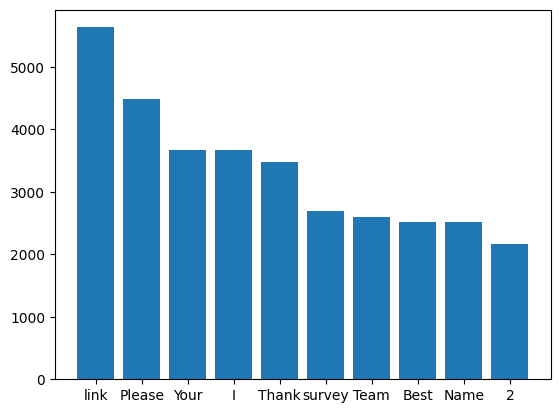

In [39]:
# plot most frequent words for whole training dataset
plt.bar(x = all_freq_dist_rm.words[:10], height = all_freq_dist_rm.freq[:10])
plt.show()

In [40]:
spam_emails = df.loc[df['Category'] == 1, ['Body']]
spam_emails

,Body
19,Invest in our revolutionary new platform and e...
23,We detected suspicious login attempts on your ...
31,A large sum of money is waiting for you. Conta...
32,Invest in our revolutionary new platform and e...
33,"Dear customer, your account has been temporari..."
...,...
15537,Want explicit SEX in 30 secs? Ring 02073162414...
15540,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
15547,Had your contract mobile 11 Mnths? Latest Moto...
15566,REMINDER FROM O2: To get 2.50 pounds free call...


In [41]:
# find the most common words of spam
spam_tokens = []


for spam in spam_emails['Body']:
    tokens = nltk.word_tokenize(spam)

    spam_tokens = spam_tokens + tokens

In [42]:
len(spam_tokens)

53655

In [43]:
# remove punctuation
spam_tokens_punct_rm = [''.join(ch for ch in word if ch not in exclude_punctuation) for word in spam_tokens]
spam_tokens_punct_rm = [word for word in spam_tokens_punct_rm if word]

In [44]:
spam_freq_dist = pd.DataFrame({'words': nltk.FreqDist(spam_tokens_punct_rm).keys(), 'freq': nltk.FreqDist(spam_tokens_punct_rm).values()})

In [45]:
spam_freq_dist

,words,freq
0,Invest,173
1,in,239
2,our,515
3,revolutionary,173
4,new,370
...,...,...
3672,REMINDER,1
3673,house,1
3674,£750,1
3675,087187272008,1


In [46]:
# drop stop words
spam_freq_dist = spam_freq_dist[~spam_freq_dist.words.isin(stp_words)].reset_index(drop=True)

In [47]:
spam_freq_dist

,words,freq
0,Invest,173
1,revolutionary,173
2,new,370
3,platform,173
4,earn,173
...,...,...
3566,REMINDER,1
3567,house,1
3568,£750,1
3569,087187272008,1


In [48]:
# sort freq values
spam_freq_dist.sort_values('freq', ascending=False, inplace=True, ignore_index=True)
spam_freq_dist

,words,freq
0,link,1362
1,new,370
2,claim,349
3,account,321
4,login,318
...,...,...
3566,Ringtone¡,1
3567,station,1
3568,toilet,1
3569,stolen,1


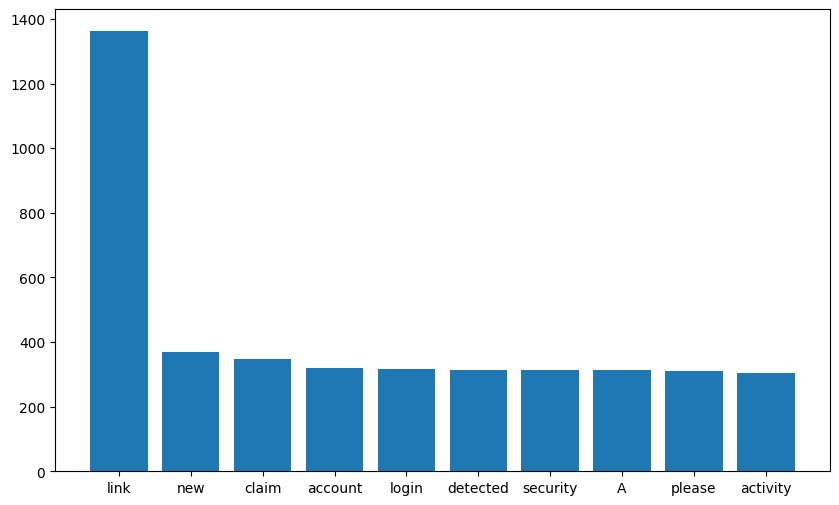

In [49]:
plt.figure(figsize=(10, 6))
plt.bar(x = spam_freq_dist.words[:10], height=spam_freq_dist.freq[:10])
plt.show()

#### Extract some more features like message word count and sentence count

In [50]:
df['Sentence_count'] = 0
df['Word_count'] = 0

index = 0
for message in df['Message']:
    sentence_count, _ = sentence_metrics([message])
    word_count, _ = word_email_metrics([message], sentence_count)

    df.at[index, 'Sentence_count'] = sentence_count
    df.at[index, 'Word_count'] = word_count

    index += 1

df.head(5)

,Message,Sender,Subject,Body,Category,Sentence_count,Word_count
0,From: support@legitcompany.com\nSubject: Regar...,support@legitcompany.com,Regarding Your Recent Inquiry,Thank you for reaching out regarding [your inq...,0,3,46
1,From: noreply@softwareupdates.com\nSubject: We...,noreply@softwareupdates.com,Weekly Newsletter - Latest Updates,Please find attached your invoice for the serv...,0,5,57
2,From: noreply@softwareupdates.com\nSubject: Im...,noreply@softwareupdates.com,Important: Software Update Notification,Thank you for your order #6789. Your items wil...,0,4,51
3,From: info@customerservice.co\nSubject: Team S...,info@customerservice.co,Team Stand-up at 10 AM,Please find attached your invoice for the serv...,0,5,57
4,From: info@customerservice.co\nSubject: Team S...,info@customerservice.co,Team Stand-up at 10 AM,Here's your weekly dose of news and updates fr...,0,4,57


In [51]:
# moving Category to the end
cols = [col for col in df.columns if col != column_to_move]
cols.append(column_to_move)

df = df[cols]
df.head(1)

,Message,Sender,Subject,Body,Sentence_count,Word_count,Category
0,From: support@legitcompany.com\nSubject: Regar...,support@legitcompany.com,Regarding Your Recent Inquiry,Thank you for reaching out regarding [your inq...,3,46,0


##### Perform text cleaning

##### Cleaning Subject and Body

In [52]:
def is_url(url_string):
    try:
        result = urlparse(url_string)

        # check for url schem and network location
        return all([result.scheme, result.netloc])
    except ValueError:
        return False

In [53]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [54]:
# use .split() instead of nltk.word_tokenize to preserve urls (but will later replace url with a token 'url')
# new features that will be created
# create the lemmatizer object
lemmatizer = WordNetLemmatizer()

df['urls_found'] = 0

token_pattern = re.compile(r'https?://\S+|www\.\S+|\S+')

# columns to clean
columns_to_clean = ['Subject', 'Body']

for col in columns_to_clean:
    for idx, raw_text in df[col].fillna('').astype(str).items():
        text = raw_text.lower()

        # get tokens
        tokens = token_pattern.findall(text)

        url_count = sum(1 for t in tokens if is_url(t))
        df.at[idx, 'urls_found'] = url_count

        # substitute urls with 'url'
        tokens = ['url' if is_url(t) else t for t in tokens]

        # do PoS tagging-lemmatization
        # get Pos tag
        tagged = nltk.pos_tag(tokens)
        lemma_tokens = []

        for word, tag in tagged:
            new_tag = pos_tagger(tag)
            lemma = lemmatizer.lemmatize(word, new_tag)
            lemma_tokens.append(lemma)

        # remove stop words and punctuation
        text_clean = [
            word for word in lemma_tokens 
            if word and (word not in stp_words) and (not all(ch in exclude_punctuation for ch in word))
        ]

        df.at[idx, col] = ' '.join(text_clean).strip()

In [55]:
df['Body'].values

array(['thank reach regard [your inquiry]. review request get back within 24 hour detailed response. sincerely, customer service team',
       'please find attached invoice service render june. total amount due $x.xx. payment due [date]. questions, please reply email. thank you, account department',
       'thank order #6789. item ship within 2 business days. track order here: [link legitimate track page]. best regards, legit company support',
       ..., 'pity, mood that. so...any suggestions?',
       'guy bitching act like interested buy something else next week give u free',
       'rofl. true name'], shape=(15572,), dtype=object)

##### Do some sentiment analysis

In [ ]:
classifier = pipeline("sentiment-analysis", model="tabularisai/multilingual-sentiment-analysis")

Device set to use cpu


In [ ]:
df['Sentiment'] = classifier(df['Message'].tolist())

,Message,Sender,Subject,Body,Sentence_count,Word_count,Category,urls_found,Sentiment
0,From: support@legitcompany.com\nSubject: Regar...,support@legitcompany.com,regard recent inquiry,thank reach regard [your inquiry]. review requ...,3,46,0,0,"{'label': 'Neutral', 'score': 0.7767756581306458}"
1,From: noreply@softwareupdates.com\nSubject: We...,noreply@softwareupdates.com,weekly newsletter late update,please find attached invoice service render ju...,5,57,0,0,"{'label': 'Neutral', 'score': 0.9220107793807983}"
2,From: noreply@softwareupdates.com\nSubject: Im...,noreply@softwareupdates.com,important: software update notification,thank order #6789. item ship within 2 business...,4,51,0,0,"{'label': 'Neutral', 'score': 0.6439230442047119}"
3,From: info@customerservice.co\nSubject: Team S...,info@customerservice.co,team stand-up 10,please find attached invoice service render ju...,5,57,0,0,"{'label': 'Neutral', 'score': 0.9195998311042786}"
4,From: info@customerservice.co\nSubject: Team S...,info@customerservice.co,team stand-up 10,here's weekly dose news update community. week...,4,57,0,0,"{'label': 'Neutral', 'score': 0.9016035795211792}"


In [65]:
def getAnalysis(sentiment_result_dict):
    if sentiment_result_dict['label'] == 'Very Negative':
        return 0
    elif sentiment_result_dict['label'] == 'Negative':
        return 1
    elif sentiment_result_dict['label'] == 'Neutral':
        return 2
    elif sentiment_result_dict['label'] == 'Positive':
        return 3
    elif sentiment_result_dict['label'] == 'Very Positive':
        return 4

In [66]:
for idx, sentiment_dict in df['Sentiment'].items():
    df.at[idx, 'Sentiment'] = getAnalysis(sentiment_dict)

In [67]:
df.head(5)

,Message,Sender,Subject,Body,Sentence_count,Word_count,Category,urls_found,Sentiment
0,From: support@legitcompany.com\nSubject: Regar...,support@legitcompany.com,regard recent inquiry,thank reach regard [your inquiry]. review requ...,3,46,0,0,2
1,From: noreply@softwareupdates.com\nSubject: We...,noreply@softwareupdates.com,weekly newsletter late update,please find attached invoice service render ju...,5,57,0,0,2
2,From: noreply@softwareupdates.com\nSubject: Im...,noreply@softwareupdates.com,important: software update notification,thank order #6789. item ship within 2 business...,4,51,0,0,2
3,From: info@customerservice.co\nSubject: Team S...,info@customerservice.co,team stand-up 10,please find attached invoice service render ju...,5,57,0,0,2
4,From: info@customerservice.co\nSubject: Team S...,info@customerservice.co,team stand-up 10,here's weekly dose news update community. week...,4,57,0,0,2


In [68]:
# move category back to the end again
cols = [col for col in df.columns if col != column_to_move]
cols.append(column_to_move)

df = df[cols]
df.head(1)

,Message,Sender,Subject,Body,Sentence_count,Word_count,urls_found,Sentiment,Category
0,From: support@legitcompany.com\nSubject: Regar...,support@legitcompany.com,regard recent inquiry,thank reach regard [your inquiry]. review requ...,3,46,0,2,0


#### Export the cleaned dataframe to csv

In [69]:
df.to_csv('cleaned_email_dataset.csv')